In [1]:

#%%
import math
import numpy as np
import pandas as pd

from kneed import KneeLocator

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import Sequential
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers import LSTM

import keras
from tensorflow.keras import Sequential
from keras.layers import *
from keras.callbacks import *

import tensorflow as tf
from sklearn.model_selection import train_test_split

import sklearn

import pandas as pd

In [25]:
def get_cpu_number():
    return multiprocessing.cpu_count()


def dimensionality_reduction(vectors, n_reduction=2):
    print('Number of dimensions is {}'.format(n_reduction))
    pca = PCA(n_components=n_reduction, svd_solver='full')
    pca.fit(vectors)
    return pca.transform(vectors)

def kneighbors(vectors):
    """
    Calculates average distances for k-nearest neighbors
    :return:
    """
    k = round(math.sqrt(len(vectors)))
    print('K-neighbours = {}'.format(k))
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=-1, algorithm='auto').fit(vectors) #-1 means using all processors       
    distances, indices = nbrs.kneighbors(vectors)
    distances = [np.mean(d) for d in np.sort(distances, axis=0)]
    return distances
    
def epsilon_search(vectors):
    """
    Search epsilon for the DBSCAN clusterization
    :return:
    """
    distances=kneighbors(vectors)
    kneedle = KneeLocator(distances, list(range(len(distances))), online=True)
    epsilon = np.mean(list(kneedle.all_elbows))
    if epsilon == 0.0:
        epsilon = np.mean(distances)
    return epsilon

def dbscan(df,min_samples=5,pca=True):
    """
    Execution of the DBSCAN clusterization algorithm.
    Returns cluster labels
    :return:
    """
    cpu_number=get_cpu_number()
    vectors=df['Vector'].values.tolist()
    if pca:
        vectors = dimensionality_reduction(vectors)
    distances=kneighbors(vectors)
    epsilon=epsilon_search(vectors)
    cluster_labels = DBSCAN(eps=epsilon,
    min_samples=min_samples,
     n_jobs=cpu_number) \
    .fit_predict(vectors)
    df['cluster'] = cluster_labels
    print('DBSCAN finished with {} clusters'.format(len(set(cluster_labels))))
    return pd.DataFrame.from_dict([item for item in df.groupby('cluster').apply(func=gb_regroup)], orient='columns').sort_values(by=['cluster_size'], ascending=False)
    #return df

def gb_regroup(gb):
    #indices = [i for sublist in gb['cluster'].values for i in sublist]
    states=[sublist for sublist in gb['State'].values]
    size = len(states)    
    return {'cluster_size': size,'state':states}


###############################################################
###############################################################


#%%
def create_fake_data(len = 143, n = 100, test_size = 0.2):
    # Creates dataset similar to the ones we have
    data = []

    for i in range(n):
        data.append(np.cumsum(np.random.rand(len)*2 - 1)) 

    x_train, y_train, x_test, y_test = train_test_split(data, data, test_size = test_size, random_state = 42)

    return x_train, y_train, x_test, y_test

def preprocessing(test_size = 0.25, path = ''):
    # Loads data and fills nan
    
    data_dict = pd.read_pickle(path)
    columns = []
    for entry in data_dict:
        for col in data_dict[entry]:
            if col != 'time':
                columns.append(np.array(data_dict[entry][col]))

    columns = [i/i.max() for i in columns]
                
    x_train, x_test, y_train, y_test = train_test_split(columns, columns, test_size = test_size, random_state = 42)

    return x_train, x_test, y_train, y_test

def train_autoencoder(x_train, embedding_dimension = 2,epc=5000):
    inp_len = len(x_train[0])

    model = Sequential([Dense(inp_len, activation = 'relu'),
    Dense(100, activation = 'relu'),
    Dense(50, activation = 'relu'),
    Dense(25, activation = 'relu'),
    Dense(embedding_dimension, activation = 'relu', name = 'encoder'),
    Dense(25, activation = 'relu'),
    Dense(50, activation = 'relu'),
    Dense(100, activation = 'relu'),
    Dense(inp_len)])

    opt = tf.keras.optimizers.Adam(
        learning_rate=0.0005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam")

    model.compile(optimizer=opt,
                loss='mean_squared_error',
                metrics=['mae','acc'])

    earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

    history = model.fit(x_train, x_train, epochs = epc, batch_size = 16, verbose = 1) #callbacks=[earlyStopping],

    return model, history

def evaluate_autoencoder(model, x_test, index = 0):
    # Make predictions on entire test set
    predictions = model.predict(x_test)

    # Use score method to get accuracy of model
    mse = sklearn.metrics.mean_squared_error(x_test, predictions)

    print(mse)

    plt.figure(figsize = (10,8))
    plt.plot(x_test[index], color = 'red')
    plt.plot(predictions[index], color = 'green')
    #plt.plot(x_train[0] - predictions[0], color = 'grey')

def get_embedding(model, data):
    intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer(index=4).output)

    embedding = intermediate_layer_model.predict(data)

    return embedding

def embed_dataset(path, model):
    data_dict = pd.read_pickle(path)

    columns = []

    for entry in data_dict:
        for col in data_dict[entry]:
            if col != 'time':
                columns.append(np.array(data_dict[entry][col]))

    columns = [i/i.max() for i in columns]

    embedding = get_embedding(model, np.array(columns))

    emb_dict = {}

    for entry, emb in zip(data_dict, embedding):
        emb_dict[entry] = emb

    return emb_dict

def pipeline(embedding_dimension,epo):
    x_train, x_test, y_train, y_test = preprocessing(path = 'data/data_merged/all_data.pkl', test_size=0.01)

    model, history = train_autoencoder(np.array(x_train), embedding_dimension=embedding_dimension,epc=epo)

    #evaluate_autoencoder(model, np.array(x_test), index = np.random.randint(0,len(x_test)-1))
    evaluate_autoencoder(model, np.array(x_test), index = np.random.randint(0,len(x_test)-1))

    #emb = get_embedding(model, np.array(x_test))

    embedding = embed_dataset('data/data_merged/all_data.pkl', model)

    df = pd.DataFrame()
    df['State'] = embedding.keys()
    df['Vector'] = [embedding[val] for val in embedding.keys()]

    cl=dbscan(df,pca=True)   

    pca = dimensionality_reduction([embedding[val] for val in embedding.keys()])

    df['PCA'] = [i for i in pca]
    plt.figure(figsize = (10,8))
    for i in df['cluster'].unique():
        dat = df.query('cluster == ' + str(i))['PCA']
        plt.scatter([i[0] for i in dat], [i[1] for i in dat])
    plt.title(embedding_dimension)
    plt.show()
    plt.close()
    return df

Epoch 1/5000
9/9 [==============================] - 1s 3ms/step - loss: 0.7210 - mae: 0.6409 - acc: 0.0000e+00
Epoch 2/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6408 - mae: 0.5607 - acc: 0.0145
Epoch 3/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.5125 - mae: 0.4200 - acc: 0.0217
Epoch 4/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4003 - mae: 0.3157 - acc: 0.0145
Epoch 5/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3250 - mae: 0.2301 - acc: 0.0145
Epoch 6/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2817 - mae: 0.1726 - acc: 0.0290
Epoch 7/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2627 - mae: 0.1362 - acc: 0.0000e+00
Epoch 8/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2552 - mae: 0.1171 - acc: 0.0000e+00
Epoch 9/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2524 - mae: 0.1086 - acc: 0.0217
Epoch 10/5000
9/9 [======

9/9 [==============================] - 0s 4ms/step - loss: 0.0185 - mae: 0.0765 - acc: 0.0870
Epoch 76/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0222 - mae: 0.0775 - acc: 0.1087
Epoch 77/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0247 - mae: 0.0767 - acc: 0.1087
Epoch 78/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0164 - mae: 0.0742 - acc: 0.1159
Epoch 79/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0236 - mae: 0.0761 - acc: 0.1087
Epoch 80/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0152 - mae: 0.0736 - acc: 0.1087
Epoch 81/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0154 - mae: 0.0733 - acc: 0.1304
Epoch 82/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0154 - mae: 0.0714 - acc: 0.1232
Epoch 83/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0143 - mae: 0.0716 - acc: 0.1087
Epoch 84/5000
9/9 [=======================

9/9 [==============================] - 0s 3ms/step - loss: 0.0107 - mae: 0.0619 - acc: 0.1884
Epoch 151/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0106 - mae: 0.0623 - acc: 0.1739
Epoch 152/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0106 - mae: 0.0623 - acc: 0.1667
Epoch 153/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0106 - mae: 0.0622 - acc: 0.1304
Epoch 154/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0106 - mae: 0.0622 - acc: 0.1812
Epoch 155/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0105 - mae: 0.0623 - acc: 0.1739
Epoch 156/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0105 - mae: 0.0624 - acc: 0.1594
Epoch 157/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0104 - mae: 0.0621 - acc: 0.1739
Epoch 158/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0104 - mae: 0.0623 - acc: 0.1739
Epoch 159/5000
9/9 [==============

9/9 [==============================] - 0s 4ms/step - loss: 0.0081 - mae: 0.0562 - acc: 0.2029
Epoch 226/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0081 - mae: 0.0558 - acc: 0.2101
Epoch 227/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0081 - mae: 0.0561 - acc: 0.2101
Epoch 228/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0081 - mae: 0.0554 - acc: 0.2319
Epoch 229/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0080 - mae: 0.0553 - acc: 0.2246
Epoch 230/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0080 - mae: 0.0551 - acc: 0.2029
Epoch 231/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0081 - mae: 0.0559 - acc: 0.1957
Epoch 232/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0080 - mae: 0.0555 - acc: 0.1957
Epoch 233/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0080 - mae: 0.0553 - acc: 0.2029
Epoch 234/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0522 - acc: 0.2464
Epoch 301/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0070 - mae: 0.0522 - acc: 0.2319
Epoch 302/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0070 - mae: 0.0522 - acc: 0.2101
Epoch 303/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0070 - mae: 0.0520 - acc: 0.2029
Epoch 304/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0074 - mae: 0.0532 - acc: 0.2101
Epoch 305/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0524 - acc: 0.2101
Epoch 306/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0076 - mae: 0.0533 - acc: 0.2101
Epoch 307/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0074 - mae: 0.0538 - acc: 0.2391
Epoch 308/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0069 - mae: 0.0527 - acc: 0.2029
Epoch 309/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0494 - acc: 0.2246
Epoch 376/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0061 - mae: 0.0498 - acc: 0.2536
Epoch 377/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0489 - acc: 0.2464
Epoch 378/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0065 - mae: 0.0506 - acc: 0.2029
Epoch 379/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0061 - mae: 0.0497 - acc: 0.2391
Epoch 380/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0498 - acc: 0.2536
Epoch 381/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0063 - mae: 0.0505 - acc: 0.2319
Epoch 382/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0062 - mae: 0.0499 - acc: 0.2464
Epoch 383/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0058 - mae: 0.0484 - acc: 0.2536
Epoch 384/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0202 - mae: 0.0587 - acc: 0.2391
Epoch 451/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0128 - mae: 0.0597 - acc: 0.2826
Epoch 452/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0569 - acc: 0.2681
Epoch 453/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0098 - mae: 0.0558 - acc: 0.2754
Epoch 454/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0058 - mae: 0.0513 - acc: 0.2826
Epoch 455/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0057 - mae: 0.0506 - acc: 0.2754
Epoch 456/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0057 - mae: 0.0488 - acc: 0.2754
Epoch 457/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0055 - mae: 0.0478 - acc: 0.2899
Epoch 458/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0052 - mae: 0.0471 - acc: 0.3043
Epoch 459/5000
9/9 [==============

9/9 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0438 - acc: 0.3406
Epoch 526/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0437 - acc: 0.3333
Epoch 527/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0046 - mae: 0.0443 - acc: 0.2826
Epoch 528/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0444 - acc: 0.3188
Epoch 529/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0437 - acc: 0.2754
Epoch 530/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0439 - acc: 0.3043
Epoch 531/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0044 - mae: 0.0438 - acc: 0.2826
Epoch 532/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0435 - acc: 0.3188
Epoch 533/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0044 - mae: 0.0434 - acc: 0.3188
Epoch 534/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0416 - acc: 0.3333
Epoch 601/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0415 - acc: 0.3551
Epoch 602/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0412 - acc: 0.3696
Epoch 603/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0418 - acc: 0.3333
Epoch 604/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0040 - mae: 0.0416 - acc: 0.3551
Epoch 605/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0418 - acc: 0.3261
Epoch 606/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0417 - acc: 0.3333
Epoch 607/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0417 - acc: 0.3188
Epoch 608/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0414 - acc: 0.3188
Epoch 609/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0447 - acc: 0.2971
Epoch 676/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0042 - mae: 0.0434 - acc: 0.3623
Epoch 677/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0423 - acc: 0.3333
Epoch 678/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0038 - mae: 0.0416 - acc: 0.3116
Epoch 679/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0413 - acc: 0.3188
Epoch 680/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0037 - mae: 0.0405 - acc: 0.3478
Epoch 681/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0037 - mae: 0.0409 - acc: 0.3551
Epoch 682/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0037 - mae: 0.0410 - acc: 0.3188
Epoch 683/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0036 - mae: 0.0405 - acc: 0.3333
Epoch 684/5000
9/9 [==============

9/9 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0386 - acc: 0.3261
Epoch 751/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0383 - acc: 0.3043
Epoch 752/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0380 - acc: 0.3406
Epoch 753/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0384 - acc: 0.3478
Epoch 754/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0034 - mae: 0.0391 - acc: 0.3478
Epoch 755/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0385 - acc: 0.3116
Epoch 756/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0381 - acc: 0.3623
Epoch 757/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0382 - acc: 0.3478
Epoch 758/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0379 - acc: 0.3406
Epoch 759/5000
9/9 [==============

9/9 [==============================] - 0s 4ms/step - loss: 0.0031 - mae: 0.0375 - acc: 0.3406
Epoch 826/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.0031 - mae: 0.0377 - acc: 0.3188
Epoch 827/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0378 - acc: 0.3623
Epoch 828/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0372 - acc: 0.3623
Epoch 829/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0373 - acc: 0.3623
Epoch 830/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0375 - acc: 0.3623
Epoch 831/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0036 - mae: 0.0380 - acc: 0.3333
Epoch 832/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0038 - mae: 0.0389 - acc: 0.3043
Epoch 833/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0036 - mae: 0.0384 - acc: 0.3623
Epoch 834/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0356 - acc: 0.3551
Epoch 901/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0358 - acc: 0.3623
Epoch 902/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0361 - acc: 0.3478
Epoch 903/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0359 - acc: 0.3478
Epoch 904/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0356 - acc: 0.3623
Epoch 905/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0355 - acc: 0.3768
Epoch 906/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0028 - mae: 0.0354 - acc: 0.3768
Epoch 907/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0028 - mae: 0.0357 - acc: 0.3623
Epoch 908/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0357 - acc: 0.3551
Epoch 909/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0350 - acc: 0.3551
Epoch 976/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0349 - acc: 0.3478
Epoch 977/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0345 - acc: 0.3696
Epoch 978/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0352 - acc: 0.3913
Epoch 979/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0348 - acc: 0.3841
Epoch 980/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0355 - acc: 0.3551
Epoch 981/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0358 - acc: 0.3696
Epoch 982/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0350 - acc: 0.3551
Epoch 983/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0353 - acc: 0.3623
Epoch 984/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0335 - acc: 0.3986
Epoch 1050/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0333 - acc: 0.3768
Epoch 1051/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0334 - acc: 0.3696
Epoch 1052/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0335 - acc: 0.3768
Epoch 1053/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0341 - acc: 0.3406
Epoch 1054/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0333 - acc: 0.3913
Epoch 1055/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0334 - acc: 0.3768
Epoch 1056/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0332 - acc: 0.3768
Epoch 1057/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0337 - acc: 0.4058
Epoch 1058/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0328 - acc: 0.3986
Epoch 1124/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0336 - acc: 0.3913
Epoch 1125/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0338 - acc: 0.3696
Epoch 1126/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0332 - acc: 0.3913
Epoch 1127/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0337 - acc: 0.3623
Epoch 1128/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0335 - acc: 0.3623
Epoch 1129/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0357 - acc: 0.3768
Epoch 1130/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0405 - acc: 0.3841
Epoch 1131/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0048 - mae: 0.0423 - acc: 0.3841
Epoch 1132/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0320 - acc: 0.4058
Epoch 1198/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0320 - acc: 0.3841
Epoch 1199/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0320 - acc: 0.3696
Epoch 1200/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0329 - acc: 0.3768
Epoch 1201/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0334 - acc: 0.3841
Epoch 1202/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0338 - acc: 0.3696
Epoch 1203/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0334 - acc: 0.4058
Epoch 1204/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0324 - acc: 0.4203
Epoch 1205/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0023 - mae: 0.0323 - acc: 0.3696
Epoch 1206/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0322 - acc: 0.3841
Epoch 1272/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0322 - acc: 0.3768
Epoch 1273/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0028 - mae: 0.0331 - acc: 0.3913
Epoch 1274/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0320 - acc: 0.3768
Epoch 1275/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0334 - acc: 0.3841
Epoch 1276/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0352 - acc: 0.3913
Epoch 1277/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0349 - acc: 0.3768
Epoch 1278/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0062 - mae: 0.0365 - acc: 0.3841
Epoch 1279/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0369 - acc: 0.3696
Epoch 1280/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0021 - mae: 0.0312 - acc: 0.3913
Epoch 1346/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0304 - acc: 0.3768
Epoch 1347/5000
9/9 [==============================] - 0s 7ms/step - loss: 0.0021 - mae: 0.0309 - acc: 0.4348
Epoch 1348/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.0021 - mae: 0.0309 - acc: 0.3841
Epoch 1349/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0021 - mae: 0.0308 - acc: 0.4275
Epoch 1350/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0021 - mae: 0.0312 - acc: 0.3696
Epoch 1351/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0313 - acc: 0.4058
Epoch 1352/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0308 - acc: 0.4130
Epoch 1353/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0307 - acc: 0.3913
Epoch 1354/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0310 - acc: 0.3913
Epoch 1420/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0308 - acc: 0.3913
Epoch 1421/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0303 - acc: 0.4420
Epoch 1422/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0307 - acc: 0.4130
Epoch 1423/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0307 - acc: 0.4058
Epoch 1424/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0311 - acc: 0.3986
Epoch 1425/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0021 - mae: 0.0311 - acc: 0.3841
Epoch 1426/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0316 - acc: 0.3913
Epoch 1427/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0021 - mae: 0.0310 - acc: 0.4058
Epoch 1428/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0308 - acc: 0.4058
Epoch 1494/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0311 - acc: 0.3986
Epoch 1495/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0023 - mae: 0.0310 - acc: 0.4348
Epoch 1496/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0321 - acc: 0.4203
Epoch 1497/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0329 - acc: 0.4058
Epoch 1498/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0340 - acc: 0.3768
Epoch 1499/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0028 - mae: 0.0344 - acc: 0.4130
Epoch 1500/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0340 - acc: 0.3768
Epoch 1501/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0341 - acc: 0.4058
Epoch 1502/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0287 - acc: 0.4130
Epoch 1568/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0288 - acc: 0.4348
Epoch 1569/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0288 - acc: 0.4058
Epoch 1570/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0289 - acc: 0.4348
Epoch 1571/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0019 - mae: 0.0292 - acc: 0.3986
Epoch 1572/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0287 - acc: 0.4275
Epoch 1573/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0287 - acc: 0.4348
Epoch 1574/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0289 - acc: 0.4058
Epoch 1575/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0292 - acc: 0.4348
Epoch 1576/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0345 - acc: 0.4130
Epoch 1642/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0323 - acc: 0.4275
Epoch 1643/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0326 - acc: 0.4058
Epoch 1644/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0309 - acc: 0.4203
Epoch 1645/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0317 - acc: 0.4130
Epoch 1646/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0043 - mae: 0.0332 - acc: 0.3986
Epoch 1647/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0326 - acc: 0.4203
Epoch 1648/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0322 - acc: 0.3986
Epoch 1649/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0328 - acc: 0.4058
Epoch 1650/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0322 - acc: 0.4275
Epoch 1716/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0317 - acc: 0.3841
Epoch 1717/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0318 - acc: 0.4348
Epoch 1718/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0318 - acc: 0.3768
Epoch 1719/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0314 - acc: 0.4058
Epoch 1720/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0329 - acc: 0.3623
Epoch 1721/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0142 - mae: 0.0387 - acc: 0.3841
Epoch 1722/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0053 - mae: 0.0357 - acc: 0.3913
Epoch 1723/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0349 - acc: 0.3841
Epoch 1724/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0275 - acc: 0.3986
Epoch 1790/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0017 - mae: 0.0272 - acc: 0.4420
Epoch 1791/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0273 - acc: 0.4493
Epoch 1792/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0017 - mae: 0.0273 - acc: 0.4275
Epoch 1793/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0017 - mae: 0.0277 - acc: 0.4275
Epoch 1794/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0280 - acc: 0.4275
Epoch 1795/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0277 - acc: 0.4348
Epoch 1796/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0275 - acc: 0.4203
Epoch 1797/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0279 - acc: 0.4275
Epoch 1798/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0043 - mae: 0.0368 - acc: 0.3913
Epoch 1864/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0352 - acc: 0.3696
Epoch 1865/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0357 - acc: 0.4275
Epoch 1866/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0046 - mae: 0.0350 - acc: 0.3841
Epoch 1867/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0330 - acc: 0.3768
Epoch 1868/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0046 - mae: 0.0354 - acc: 0.3623
Epoch 1869/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0375 - acc: 0.4203
Epoch 1870/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0248 - mae: 0.0425 - acc: 0.3696
Epoch 1871/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0454 - acc: 0.3841
Epoch 1872/5000
9/9 [=====

9/9 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0263 - acc: 0.4275
Epoch 1938/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0266 - acc: 0.4348
Epoch 1939/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0266 - acc: 0.4275
Epoch 1940/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0268 - acc: 0.4058
Epoch 1941/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0267 - acc: 0.4130
Epoch 1942/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0262 - acc: 0.4275
Epoch 1943/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0264 - acc: 0.4275
Epoch 1944/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0265 - acc: 0.4348
Epoch 1945/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0264 - acc: 0.4565
Epoch 1946/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0265 - acc: 0.4275
Epoch 2012/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0274 - acc: 0.4058
Epoch 2013/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0272 - acc: 0.3913
Epoch 2014/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0270 - acc: 0.4348
Epoch 2015/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0270 - acc: 0.3986
Epoch 2016/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0269 - acc: 0.4203
Epoch 2017/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0266 - acc: 0.4058
Epoch 2018/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0262 - acc: 0.4058
Epoch 2019/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0263 - acc: 0.4130
Epoch 2020/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0266 - acc: 0.4058
Epoch 2086/5000
9/9 [==============================] - 0s 7ms/step - loss: 0.0015 - mae: 0.0263 - acc: 0.4203
Epoch 2087/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0265 - acc: 0.3913
Epoch 2088/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0265 - acc: 0.4130
Epoch 2089/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0265 - acc: 0.4130
Epoch 2090/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0264 - acc: 0.3986
Epoch 2091/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0259 - acc: 0.3913
Epoch 2092/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0268 - acc: 0.4275
Epoch 2093/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0262 - acc: 0.3841
Epoch 2094/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0248 - acc: 0.3913
Epoch 2160/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0251 - acc: 0.4130
Epoch 2161/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0250 - acc: 0.4130
Epoch 2162/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0249 - acc: 0.3841
Epoch 2163/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0250 - acc: 0.4420
Epoch 2164/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0256 - acc: 0.3841
Epoch 2165/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0254 - acc: 0.3986
Epoch 2166/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0251 - acc: 0.4203
Epoch 2167/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0253 - acc: 0.4130
Epoch 2168/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0249 - acc: 0.3913
Epoch 2234/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0247 - acc: 0.4203
Epoch 2235/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0246 - acc: 0.4420
Epoch 2236/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0246 - acc: 0.4348
Epoch 2237/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0248 - acc: 0.4275
Epoch 2238/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0248 - acc: 0.4058
Epoch 2239/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0248 - acc: 0.4420
Epoch 2240/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0249 - acc: 0.4275
Epoch 2241/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0253 - acc: 0.4275
Epoch 2242/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0253 - acc: 0.4203
Epoch 2308/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0254 - acc: 0.3986
Epoch 2309/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0259 - acc: 0.4203
Epoch 2310/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0258 - acc: 0.4058
Epoch 2311/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0254 - acc: 0.4203
Epoch 2312/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0254 - acc: 0.4275
Epoch 2313/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0250 - acc: 0.4493
Epoch 2314/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0254 - acc: 0.3841
Epoch 2315/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0247 - acc: 0.3986
Epoch 2316/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0249 - acc: 0.4203
Epoch 2382/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0252 - acc: 0.4130
Epoch 2383/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0267 - acc: 0.4058
Epoch 2384/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0173 - mae: 0.0334 - acc: 0.3841
Epoch 2385/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0353 - acc: 0.4130
Epoch 2386/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.0180 - mae: 0.0412 - acc: 0.3841
Epoch 2387/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0246 - mae: 0.0436 - acc: 0.4058
Epoch 2388/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0047 - mae: 0.0443 - acc: 0.3406
Epoch 2389/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0362 - mae: 0.0465 - acc: 0.3986
Epoch 2390/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0242 - acc: 0.4058
Epoch 2456/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0240 - acc: 0.4275
Epoch 2457/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0243 - acc: 0.4203
Epoch 2458/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0238 - acc: 0.4203
Epoch 2459/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0236 - acc: 0.3986
Epoch 2460/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.4275
Epoch 2461/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0232 - acc: 0.4130
Epoch 2462/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.4203
Epoch 2463/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0235 - acc: 0.4565
Epoch 2464/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0237 - acc: 0.4275
Epoch 2530/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0239 - acc: 0.4493
Epoch 2531/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0242 - acc: 0.3986
Epoch 2532/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0238 - acc: 0.4275
Epoch 2533/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0234 - acc: 0.4275
Epoch 2534/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0236 - acc: 0.4420
Epoch 2535/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0237 - acc: 0.4203
Epoch 2536/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0238 - acc: 0.4130
Epoch 2537/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0235 - acc: 0.4130
Epoch 2538/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.4493
Epoch 2604/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0233 - acc: 0.4275
Epoch 2605/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.4275
Epoch 2606/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0232 - acc: 0.4420
Epoch 2607/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.4130
Epoch 2608/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0229 - acc: 0.4275
Epoch 2609/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.4565
Epoch 2610/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0228 - acc: 0.4203
Epoch 2611/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0228 - acc: 0.4420
Epoch 2612/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0226 - acc: 0.4275
Epoch 2678/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.4275
Epoch 2679/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0228 - acc: 0.4420
Epoch 2680/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.3986
Epoch 2681/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.4203
Epoch 2682/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.4130
Epoch 2683/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0232 - acc: 0.4275
Epoch 2684/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0234 - acc: 0.4348
Epoch 2685/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0233 - acc: 0.4348
Epoch 2686/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0254 - acc: 0.3986
Epoch 2752/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0012 - mae: 0.0241 - acc: 0.4420
Epoch 2753/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0239 - acc: 0.4058
Epoch 2754/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.4058
Epoch 2755/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0233 - acc: 0.4058
Epoch 2756/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0234 - acc: 0.4348
Epoch 2757/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0245 - acc: 0.4275
Epoch 2758/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0242 - acc: 0.4493
Epoch 2759/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0240 - acc: 0.4058
Epoch 2760/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0228 - acc: 0.4203
Epoch 2826/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0225 - acc: 0.4420
Epoch 2827/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0226 - acc: 0.4130
Epoch 2828/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0226 - acc: 0.4058
Epoch 2829/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0222 - acc: 0.4348
Epoch 2830/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0224 - acc: 0.4275
Epoch 2831/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0223 - acc: 0.3986
Epoch 2832/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0223 - acc: 0.4348
Epoch 2833/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0224 - acc: 0.3986
Epoch 2834/5000
9/9 [=====

9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0222 - acc: 0.4348
Epoch 2900/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0220 - acc: 0.4348
Epoch 2901/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0219 - acc: 0.4275
Epoch 2902/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0013 - mae: 0.0223 - acc: 0.4130
Epoch 2903/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0014 - mae: 0.0234 - acc: 0.4275
Epoch 2904/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0233 - acc: 0.3841
Epoch 2905/5000
9/9 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0226 - acc: 0.437 - 0s 5ms/step - loss: 0.0011 - mae: 0.0232 - acc: 0.4275
Epoch 2906/5000
9/9 [==============================] - 0s 6ms/step - loss: 0.0012 - mae: 0.0229 - acc: 0.4348
Epoch 2907/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0012 - 

9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0214 - acc: 0.4565
Epoch 2974/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.0011 - mae: 0.0213 - acc: 0.4203
Epoch 2975/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0216 - acc: 0.4565
Epoch 2976/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0220 - acc: 0.4420
Epoch 2977/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0218 - acc: 0.4203
Epoch 2978/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0216 - acc: 0.4275
Epoch 2979/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0217 - acc: 0.4420
Epoch 2980/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0222 - acc: 0.4348
Epoch 2981/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0222 - acc: 0.4348
Epoch 2982/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0286 - acc: 0.3986
Epoch 3048/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0269 - acc: 0.4130
Epoch 3049/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0018 - mae: 0.0259 - acc: 0.4275
Epoch 3050/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0012 - mae: 0.0236 - acc: 0.4058
Epoch 3051/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.4493
Epoch 3052/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0235 - acc: 0.4203
Epoch 3053/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0229 - acc: 0.4420
Epoch 3054/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0224 - acc: 0.3986
Epoch 3055/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0231 - acc: 0.4275
Epoch 3056/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0262 - acc: 0.4130
Epoch 3122/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0277 - acc: 0.3986
Epoch 3123/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0280 - acc: 0.4203
Epoch 3124/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0298 - acc: 0.3986
Epoch 3125/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0061 - mae: 0.0327 - acc: 0.4130
Epoch 3126/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0024 - mae: 0.0305 - acc: 0.4058
Epoch 3127/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0018 - mae: 0.0299 - acc: 0.4058
Epoch 3128/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0282 - acc: 0.4130
Epoch 3129/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0018 - mae: 0.0297 - acc: 0.3841
Epoch 3130/5000
9/9 [=====

9/9 [==============================] - 0s 4ms/step - loss: 9.8864e-04 - mae: 0.0209 - acc: 0.4493
Epoch 3195/5000
9/9 [==============================] - 0s 5ms/step - loss: 9.9525e-04 - mae: 0.0211 - acc: 0.4348
Epoch 3196/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.9864e-04 - mae: 0.0211 - acc: 0.4275
Epoch 3197/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.9458e-04 - mae: 0.0211 - acc: 0.4275
Epoch 3198/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0212 - acc: 0.4130
Epoch 3199/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.9654e-04 - mae: 0.0210 - acc: 0.4420
Epoch 3200/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0212 - acc: 0.4203
Epoch 3201/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0213 - acc: 0.4493
Epoch 3202/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.8699e-04 - mae: 0.0210 - acc: 0.4420
Ep

9/9 [==============================] - 0s 4ms/step - loss: 9.6783e-04 - mae: 0.0207 - acc: 0.4203
Epoch 3268/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.6205e-04 - mae: 0.0205 - acc: 0.4565
Epoch 3269/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.5715e-04 - mae: 0.0205 - acc: 0.4420
Epoch 3270/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.5925e-04 - mae: 0.0204 - acc: 0.4348
Epoch 3271/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7062e-04 - mae: 0.0207 - acc: 0.4275
Epoch 3272/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.5460e-04 - mae: 0.0203 - acc: 0.4420
Epoch 3273/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.6110e-04 - mae: 0.0205 - acc: 0.4928
Epoch 3274/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.4998e-04 - mae: 0.0202 - acc: 0.4203
Epoch 3275/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.4720e-04 - mae: 0.0202 - ac

9/9 [==============================] - 0s 3ms/step - loss: 9.6811e-04 - mae: 0.0208 - acc: 0.4275
Epoch 3341/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6718e-04 - mae: 0.0208 - acc: 0.4710
Epoch 3342/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6652e-04 - mae: 0.0207 - acc: 0.3986
Epoch 3343/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.5194e-04 - mae: 0.0205 - acc: 0.4420
Epoch 3344/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3385e-04 - mae: 0.0201 - acc: 0.4348
Epoch 3345/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3274e-04 - mae: 0.0200 - acc: 0.4493
Epoch 3346/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2744e-04 - mae: 0.0201 - acc: 0.4275
Epoch 3347/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.4474e-04 - mae: 0.0202 - acc: 0.4420
Epoch 3348/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3730e-04 - mae: 0.0202 - ac

9/9 [==============================] - 0s 3ms/step - loss: 9.9428e-04 - mae: 0.0217 - acc: 0.4420
Epoch 3413/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7593e-04 - mae: 0.0213 - acc: 0.4348
Epoch 3414/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0217 - acc: 0.4493
Epoch 3415/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0219 - acc: 0.4420
Epoch 3416/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0217 - acc: 0.4348
Epoch 3417/5000
9/9 [==============================] - 0s 5ms/step - loss: 9.6347e-04 - mae: 0.0211 - acc: 0.4420
Epoch 3418/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.5331e-04 - mae: 0.0208 - acc: 0.4130
Epoch 3419/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.4068e-04 - mae: 0.0205 - acc: 0.4203
Epoch 3420/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.3326e-04 - mae: 0.0203 - acc: 0.4565
Ep

9/9 [==============================] - 0s 2ms/step - loss: 9.3176e-04 - mae: 0.0205 - acc: 0.4203
Epoch 3485/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.5186e-04 - mae: 0.0209 - acc: 0.4420
Epoch 3486/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.2030e-04 - mae: 0.0203 - acc: 0.4058
Epoch 3487/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.0664e-04 - mae: 0.0200 - acc: 0.4275
Epoch 3488/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.0157e-04 - mae: 0.0199 - acc: 0.4275
Epoch 3489/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.1835e-04 - mae: 0.0202 - acc: 0.4130
Epoch 3490/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.1706e-04 - mae: 0.0202 - acc: 0.4493
Epoch 3491/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.1567e-04 - mae: 0.0201 - acc: 0.4203
Epoch 3492/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3271e-04 - mae: 0.0204 - ac

9/9 [==============================] - 0s 2ms/step - loss: 0.0010 - mae: 0.0221 - acc: 0.4565
Epoch 3557/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0226 - acc: 0.4565
Epoch 3558/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0236 - acc: 0.4348
Epoch 3559/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0237 - acc: 0.4493
Epoch 3560/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0277 - acc: 0.3986
Epoch 3561/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0320 - acc: 0.4275
Epoch 3562/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0309 - acc: 0.4058
Epoch 3563/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0305 - acc: 0.3986
Epoch 3564/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0347 - mae: 0.0372 - acc: 0.3841
Epoch 3565/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 8.6478e-04 - mae: 0.0194 - acc: 0.4493
Epoch 3629/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.6211e-04 - mae: 0.0193 - acc: 0.4420
Epoch 3630/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.7461e-04 - mae: 0.0196 - acc: 0.4420
Epoch 3631/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.6825e-04 - mae: 0.0195 - acc: 0.4420
Epoch 3632/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.6923e-04 - mae: 0.0196 - acc: 0.4493
Epoch 3633/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.5907e-04 - mae: 0.0193 - acc: 0.4493
Epoch 3634/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.6215e-04 - mae: 0.0194 - acc: 0.4420
Epoch 3635/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.8049e-04 - mae: 0.0198 - acc: 0.4348
Epoch 3636/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.7969e-04 - mae: 0.0197 - ac

9/9 [==============================] - 0s 3ms/step - loss: 8.8341e-04 - mae: 0.0201 - acc: 0.4855
Epoch 3701/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.7939e-04 - mae: 0.0201 - acc: 0.4420
Epoch 3702/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8364e-04 - mae: 0.0200 - acc: 0.4710
Epoch 3703/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.8319e-04 - mae: 0.0201 - acc: 0.4275
Epoch 3704/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.2657e-04 - mae: 0.0207 - acc: 0.4710
Epoch 3705/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7645e-04 - mae: 0.0212 - acc: 0.4130
Epoch 3706/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.2920e-04 - mae: 0.0210 - acc: 0.4493
Epoch 3707/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0214 - acc: 0.4493
Epoch 3708/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0229 - acc: 0.456

9/9 [==============================] - 0s 2ms/step - loss: 8.6090e-04 - mae: 0.0198 - acc: 0.4493
Epoch 3774/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.5927e-04 - mae: 0.0196 - acc: 0.4638
Epoch 3775/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.5974e-04 - mae: 0.0197 - acc: 0.4493
Epoch 3776/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.4379e-04 - mae: 0.0194 - acc: 0.4710
Epoch 3777/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.3549e-04 - mae: 0.0191 - acc: 0.4565
Epoch 3778/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.3441e-04 - mae: 0.0192 - acc: 0.4565
Epoch 3779/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.5070e-04 - mae: 0.0194 - acc: 0.4565
Epoch 3780/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.4765e-04 - mae: 0.0194 - acc: 0.4565
Epoch 3781/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8122e-04 - mae: 0.0197 - ac

9/9 [==============================] - 0s 2ms/step - loss: 8.0384e-04 - mae: 0.0186 - acc: 0.4565
Epoch 3846/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.0316e-04 - mae: 0.0186 - acc: 0.4710
Epoch 3847/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1024e-04 - mae: 0.0187 - acc: 0.4565
Epoch 3848/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.1917e-04 - mae: 0.0189 - acc: 0.4565
Epoch 3849/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.1569e-04 - mae: 0.0188 - acc: 0.4565
Epoch 3850/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.1752e-04 - mae: 0.0189 - acc: 0.4638
Epoch 3851/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.1979e-04 - mae: 0.0190 - acc: 0.4420
Epoch 3852/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.1451e-04 - mae: 0.0188 - acc: 0.4855
Epoch 3853/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.2150e-04 - mae: 0.0189 - ac

Epoch 3917/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.9290e-04 - mae: 0.0200 - acc: 0.4710
Epoch 3918/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0224 - acc: 0.4493
Epoch 3919/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0018 - mae: 0.0254 - acc: 0.4420
Epoch 3920/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0245 - acc: 0.4493
Epoch 3921/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0012 - mae: 0.0237 - acc: 0.4493
Epoch 3922/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0010 - mae: 0.0226 - acc: 0.4638
Epoch 3923/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.6397e-04 - mae: 0.0216 - acc: 0.4638
Epoch 3924/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.8583e-04 - mae: 0.0205 - acc: 0.4783
Epoch 3925/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.5060e-04 - mae: 0.0206 - acc: 0

9/9 [==============================] - 0s 3ms/step - loss: 9.8316e-04 - mae: 0.0220 - acc: 0.4130
Epoch 3990/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.8454e-04 - mae: 0.0205 - acc: 0.4420
Epoch 3991/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.6249e-04 - mae: 0.0199 - acc: 0.4203
Epoch 3992/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.2572e-04 - mae: 0.0193 - acc: 0.4710
Epoch 3993/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.2050e-04 - mae: 0.0193 - acc: 0.4275
Epoch 3994/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1037e-04 - mae: 0.0190 - acc: 0.4638
Epoch 3995/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1763e-04 - mae: 0.0192 - acc: 0.4855
Epoch 3996/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0744e-04 - mae: 0.0190 - acc: 0.5000
Epoch 3997/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9602e-04 - mae: 0.0186 - ac

9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0214 - acc: 0.4565
Epoch 4062/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.3869e-04 - mae: 0.0211 - acc: 0.4783
Epoch 4063/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3105e-04 - mae: 0.0208 - acc: 0.4783
Epoch 4064/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2310e-04 - mae: 0.0205 - acc: 0.4493
Epoch 4065/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.9061e-04 - mae: 0.0207 - acc: 0.4710
Epoch 4066/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0020 - mae: 0.0225 - acc: 0.4420
Epoch 4067/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0225 - acc: 0.4420
Epoch 4068/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0038 - mae: 0.0262 - acc: 0.4638
Epoch 4069/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0012 - mae: 0.0239 - acc: 0.4348
Epoch 4070

9/9 [==============================] - 0s 3ms/step - loss: 7.9020e-04 - mae: 0.0187 - acc: 0.4565
Epoch 4134/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8540e-04 - mae: 0.0187 - acc: 0.4783
Epoch 4135/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0898e-04 - mae: 0.0191 - acc: 0.4565
Epoch 4136/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.2690e-04 - mae: 0.0195 - acc: 0.4638
Epoch 4137/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.0239e-04 - mae: 0.0191 - acc: 0.4710
Epoch 4138/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.3070e-04 - mae: 0.0197 - acc: 0.4565
Epoch 4139/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.4837e-04 - mae: 0.0199 - acc: 0.4493
Epoch 4140/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.3714e-04 - mae: 0.0197 - acc: 0.4565
Epoch 4141/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1997e-04 - mae: 0.0193 - ac

9/9 [==============================] - 0s 2ms/step - loss: 8.2401e-04 - mae: 0.0195 - acc: 0.4565
Epoch 4206/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0272e-04 - mae: 0.0192 - acc: 0.4928
Epoch 4207/5000
9/9 [==============================] - 0s 5ms/step - loss: 8.3001e-04 - mae: 0.0193 - acc: 0.4420
Epoch 4208/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1722e-04 - mae: 0.0194 - acc: 0.4783
Epoch 4209/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.5280e-04 - mae: 0.0197 - acc: 0.4420
Epoch 4210/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.0335e-04 - mae: 0.0193 - acc: 0.5000
Epoch 4211/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9927e-04 - mae: 0.0191 - acc: 0.4565
Epoch 4212/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.0187e-04 - mae: 0.0191 - acc: 0.4710
Epoch 4213/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8321e-04 - mae: 0.0188 - ac

9/9 [==============================] - 0s 3ms/step - loss: 8.4317e-04 - mae: 0.0191 - acc: 0.4493
Epoch 4278/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9760e-04 - mae: 0.0191 - acc: 0.4638
Epoch 4279/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.1369e-04 - mae: 0.0195 - acc: 0.4638
Epoch 4280/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0200 - acc: 0.4855
Epoch 4281/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1834e-04 - mae: 0.0196 - acc: 0.4710
Epoch 4282/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.4270e-04 - mae: 0.0199 - acc: 0.4710
Epoch 4283/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0203 - acc: 0.4348
Epoch 4284/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6654e-04 - mae: 0.0203 - acc: 0.4565
Epoch 4285/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0024 - mae: 0.0231 - acc: 0.4565
Ep

9/9 [==============================] - 0s 4ms/step - loss: 8.0627e-04 - mae: 0.0195 - acc: 0.4638
Epoch 4350/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.9324e-04 - mae: 0.0192 - acc: 0.4710
Epoch 4351/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.1345e-04 - mae: 0.0196 - acc: 0.4565
Epoch 4352/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.9910e-04 - mae: 0.0193 - acc: 0.4710
Epoch 4353/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.9066e-04 - mae: 0.0193 - acc: 0.4783
Epoch 4354/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9191e-04 - mae: 0.0190 - acc: 0.4493
Epoch 4355/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8420e-04 - mae: 0.0190 - acc: 0.4420
Epoch 4356/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.7439e-04 - mae: 0.0189 - acc: 0.4928
Epoch 4357/5000
9/9 [==============================] - 0s 2ms/step - loss: 7.9261e-04 - mae: 0.0191 - ac

9/9 [==============================] - 0s 3ms/step - loss: 7.5639e-04 - mae: 0.0185 - acc: 0.4783
Epoch 4423/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5660e-04 - mae: 0.0183 - acc: 0.4710
Epoch 4424/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4523e-04 - mae: 0.0182 - acc: 0.4710
Epoch 4425/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4477e-04 - mae: 0.0181 - acc: 0.4928
Epoch 4426/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.6401e-04 - mae: 0.0185 - acc: 0.4783
Epoch 4427/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5623e-04 - mae: 0.0183 - acc: 0.4783
Epoch 4428/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4293e-04 - mae: 0.0182 - acc: 0.4783
Epoch 4429/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3378e-04 - mae: 0.0179 - acc: 0.5000
Epoch 4430/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3376e-04 - mae: 0.0179 - ac

9/9 [==============================] - 0s 3ms/step - loss: 7.7141e-04 - mae: 0.0188 - acc: 0.4710
Epoch 4495/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.5596e-04 - mae: 0.0187 - acc: 0.5072
Epoch 4496/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5116e-04 - mae: 0.0185 - acc: 0.4638
Epoch 4497/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3388e-04 - mae: 0.0180 - acc: 0.5000
Epoch 4498/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3982e-04 - mae: 0.0182 - acc: 0.4565
Epoch 4499/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5201e-04 - mae: 0.0185 - acc: 0.4710
Epoch 4500/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5086e-04 - mae: 0.0185 - acc: 0.4638
Epoch 4501/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.7216e-04 - mae: 0.0190 - acc: 0.4493
Epoch 4502/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.3637e-04 - mae: 0.0190 - ac

9/9 [==============================] - 0s 3ms/step - loss: 7.2356e-04 - mae: 0.0179 - acc: 0.4710
Epoch 4567/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.1479e-04 - mae: 0.0178 - acc: 0.4855
Epoch 4568/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.1695e-04 - mae: 0.0178 - acc: 0.4855
Epoch 4569/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.1654e-04 - mae: 0.0178 - acc: 0.4710
Epoch 4570/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.0841e-04 - mae: 0.0176 - acc: 0.4855
Epoch 4571/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.0712e-04 - mae: 0.0176 - acc: 0.4855
Epoch 4572/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.1497e-04 - mae: 0.0178 - acc: 0.5000
Epoch 4573/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.1206e-04 - mae: 0.0177 - acc: 0.4855
Epoch 4574/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.1231e-04 - mae: 0.0177 - ac

9/9 [==============================] - 0s 3ms/step - loss: 8.2036e-04 - mae: 0.0193 - acc: 0.4638
Epoch 4639/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.7706e-04 - mae: 0.0191 - acc: 0.4783
Epoch 4640/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0202 - acc: 0.4638
Epoch 4641/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0229 - acc: 0.4710
Epoch 4642/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0043 - mae: 0.0237 - acc: 0.4420
Epoch 4643/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0263 - acc: 0.5000
Epoch 4644/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0261 - acc: 0.4130
Epoch 4645/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0231 - acc: 0.4275
Epoch 4646/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0226 - acc: 0.4565
Epoch 4647/5000
9/

9/9 [==============================] - 0s 3ms/step - loss: 7.2412e-04 - mae: 0.0176 - acc: 0.4638
Epoch 4711/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.0680e-04 - mae: 0.0176 - acc: 0.4710
Epoch 4712/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.8993e-04 - mae: 0.0175 - acc: 0.4710
Epoch 4713/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4394e-04 - mae: 0.0177 - acc: 0.4638
Epoch 4714/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9764e-04 - mae: 0.0178 - acc: 0.4710
Epoch 4715/5000
9/9 [==============================] - 0s 2ms/step - loss: 7.9723e-04 - mae: 0.0179 - acc: 0.4783
Epoch 4716/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.2776e-04 - mae: 0.0184 - acc: 0.4638
Epoch 4717/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0207 - acc: 0.4638
Epoch 4718/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0227 - acc: 0.463

9/9 [==============================] - 0s 2ms/step - loss: 6.6801e-04 - mae: 0.0169 - acc: 0.4783
Epoch 4783/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.7485e-04 - mae: 0.0170 - acc: 0.4783
Epoch 4784/5000
9/9 [==============================] - 0s 4ms/step - loss: 6.7236e-04 - mae: 0.0170 - acc: 0.4638
Epoch 4785/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.6249e-04 - mae: 0.0169 - acc: 0.4783
Epoch 4786/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.7103e-04 - mae: 0.0170 - acc: 0.5072
Epoch 4787/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.7654e-04 - mae: 0.0170 - acc: 0.4638
Epoch 4788/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.8046e-04 - mae: 0.0171 - acc: 0.4710
Epoch 4789/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.8124e-04 - mae: 0.0172 - acc: 0.4638
Epoch 4790/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.8768e-04 - mae: 0.0173 - ac

9/9 [==============================] - 0s 3ms/step - loss: 9.0655e-04 - mae: 0.0197 - acc: 0.4783
Epoch 4855/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.9935e-04 - mae: 0.0204 - acc: 0.4855
Epoch 4856/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8972e-04 - mae: 0.0197 - acc: 0.4928
Epoch 4857/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0206 - acc: 0.4855
Epoch 4858/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0216 - acc: 0.4855
Epoch 4859/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0227 - acc: 0.4493
Epoch 4860/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0243 - acc: 0.5000
Epoch 4861/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0253 - acc: 0.4638
Epoch 4862/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.4591e-04 - mae: 0.0223 - acc: 0.4638
Epoch 4863

Epoch 4927/5000
9/9 [==============================] - 0s 2ms/step - loss: 6.7459e-04 - mae: 0.0173 - acc: 0.4710
Epoch 4928/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.7540e-04 - mae: 0.0172 - acc: 0.4928
Epoch 4929/5000
9/9 [==============================] - 0s 2ms/step - loss: 6.6634e-04 - mae: 0.0170 - acc: 0.4638
Epoch 4930/5000
9/9 [==============================] - 0s 2ms/step - loss: 6.6196e-04 - mae: 0.0171 - acc: 0.4928
Epoch 4931/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.6876e-04 - mae: 0.0172 - acc: 0.4855
Epoch 4932/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.8290e-04 - mae: 0.0176 - acc: 0.4783
Epoch 4933/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.8227e-04 - mae: 0.0175 - acc: 0.4855
Epoch 4934/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.7059e-04 - mae: 0.0172 - acc: 0.4710
Epoch 4935/5000
9/9 [==============================] - 0s 4ms/step - loss: 6.7075e-04 - 

9/9 [==============================] - 0s 3ms/step - loss: 6.7345e-04 - mae: 0.0175 - acc: 0.4638
Epoch 4999/5000
9/9 [==============================] - 0s 3ms/step - loss: 6.7291e-04 - mae: 0.0174 - acc: 0.4710
Epoch 5000/5000
9/9 [==============================] - 0s 2ms/step - loss: 6.7760e-04 - mae: 0.0176 - acc: 0.4928
0.008420594282749237
Number of dimensions is 2
K-neighbours = 5
K-neighbours = 5
DBSCAN finished with 2 clusters
Number of dimensions is 2


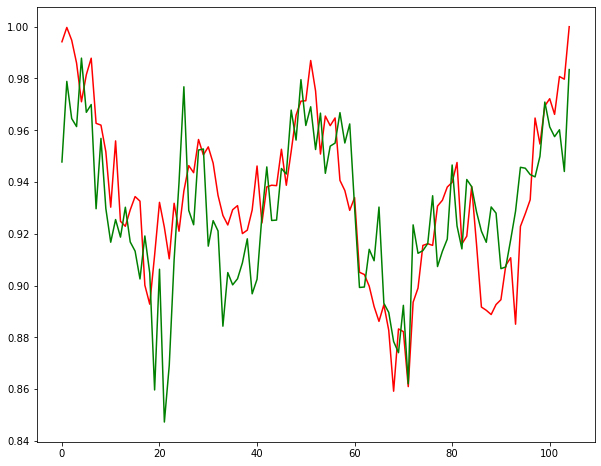

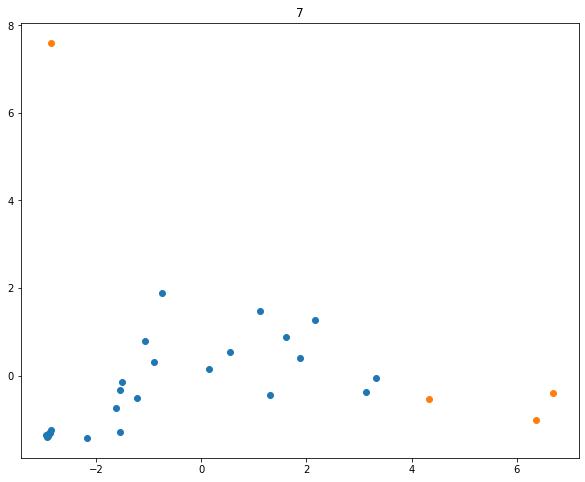

In [29]:
p7=pipeline(7,5000)

Epoch 1/5000
9/9 [==============================] - 1s 3ms/step - loss: 0.7333 - mae: 0.6511 - acc: 0.0072
Epoch 2/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7138 - mae: 0.6375 - acc: 0.0145
Epoch 3/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6567 - mae: 0.5942 - acc: 0.0145
Epoch 4/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5225 - mae: 0.4539 - acc: 0.0145
Epoch 5/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.4091 - mae: 0.3279 - acc: 0.0145
Epoch 6/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3347 - mae: 0.2474 - acc: 0.0145
Epoch 7/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2916 - mae: 0.1925 - acc: 0.0145
Epoch 8/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2689 - mae: 0.1553 - acc: 0.0145
Epoch 9/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2560 - mae: 0.1311 - acc: 0.0145
Epoch 10/5000
9/9 [==================

9/9 [==============================] - 0s 3ms/step - loss: 0.0146 - mae: 0.0744 - acc: 0.0942
Epoch 77/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0143 - mae: 0.0737 - acc: 0.1014
Epoch 78/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0142 - mae: 0.0740 - acc: 0.1014
Epoch 79/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0141 - mae: 0.0735 - acc: 0.1232
Epoch 80/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0142 - mae: 0.0739 - acc: 0.1304
Epoch 81/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0141 - mae: 0.0734 - acc: 0.1159
Epoch 82/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0140 - mae: 0.0735 - acc: 0.1159
Epoch 83/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0141 - mae: 0.0736 - acc: 0.1377
Epoch 84/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0139 - mae: 0.0729 - acc: 0.1304
Epoch 85/5000
9/9 [=======================

9/9 [==============================] - 0s 4ms/step - loss: 0.0097 - mae: 0.0607 - acc: 0.1739
Epoch 152/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0101 - mae: 0.0607 - acc: 0.1232
Epoch 153/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0097 - mae: 0.0600 - acc: 0.1667
Epoch 154/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0094 - mae: 0.0601 - acc: 0.1884
Epoch 155/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0098 - mae: 0.0598 - acc: 0.1884
Epoch 156/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0098 - mae: 0.0599 - acc: 0.1739
Epoch 157/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0094 - mae: 0.0596 - acc: 0.1957
Epoch 158/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0137 - mae: 0.0636 - acc: 0.1594
Epoch 159/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0098 - mae: 0.0607 - acc: 0.1594
Epoch 160/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0073 - mae: 0.0530 - acc: 0.1812
Epoch 227/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0073 - mae: 0.0533 - acc: 0.2101
Epoch 228/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0530 - acc: 0.1957
Epoch 229/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0072 - mae: 0.0533 - acc: 0.2174
Epoch 230/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0072 - mae: 0.0533 - acc: 0.2101
Epoch 231/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0527 - acc: 0.2174
Epoch 232/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0534 - acc: 0.2029
Epoch 233/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0073 - mae: 0.0539 - acc: 0.2246
Epoch 234/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0536 - acc: 0.2029
Epoch 235/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0068 - mae: 0.0504 - acc: 0.2391
Epoch 302/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0071 - mae: 0.0507 - acc: 0.2319
Epoch 303/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0062 - mae: 0.0501 - acc: 0.2174
Epoch 304/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0077 - mae: 0.0512 - acc: 0.2609
Epoch 305/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0066 - mae: 0.0503 - acc: 0.2029
Epoch 306/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0062 - mae: 0.0495 - acc: 0.2174
Epoch 307/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0063 - mae: 0.0498 - acc: 0.2391
Epoch 308/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0061 - mae: 0.0493 - acc: 0.2391
Epoch 309/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0061 - mae: 0.0489 - acc: 0.2319
Epoch 310/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0056 - mae: 0.0476 - acc: 0.2246
Epoch 377/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0055 - mae: 0.0476 - acc: 0.2391
Epoch 378/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0055 - mae: 0.0478 - acc: 0.2101
Epoch 379/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0055 - mae: 0.0474 - acc: 0.2174
Epoch 380/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0055 - mae: 0.0476 - acc: 0.2391
Epoch 381/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0054 - mae: 0.0467 - acc: 0.2536
Epoch 382/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0055 - mae: 0.0475 - acc: 0.2391
Epoch 383/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0056 - mae: 0.0478 - acc: 0.2319
Epoch 384/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0057 - mae: 0.0476 - acc: 0.2319
Epoch 385/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0051 - mae: 0.0458 - acc: 0.2609
Epoch 452/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0050 - mae: 0.0459 - acc: 0.2464
Epoch 453/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0051 - mae: 0.0463 - acc: 0.3043
Epoch 454/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0053 - mae: 0.0462 - acc: 0.2391
Epoch 455/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0051 - mae: 0.0461 - acc: 0.2971
Epoch 456/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0050 - mae: 0.0460 - acc: 0.2609
Epoch 457/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0052 - mae: 0.0468 - acc: 0.2536
Epoch 458/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0050 - mae: 0.0460 - acc: 0.2971
Epoch 459/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0050 - mae: 0.0453 - acc: 0.2609
Epoch 460/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0054 - mae: 0.0494 - acc: 0.2609
Epoch 527/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0137 - mae: 0.0567 - acc: 0.2391
Epoch 528/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0203 - mae: 0.0558 - acc: 0.2464
Epoch 529/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0057 - mae: 0.0510 - acc: 0.2681
Epoch 530/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0065 - mae: 0.0501 - acc: 0.2536
Epoch 531/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0489 - acc: 0.2536
Epoch 532/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0050 - mae: 0.0466 - acc: 0.2754
Epoch 533/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0049 - mae: 0.0457 - acc: 0.2681
Epoch 534/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0048 - mae: 0.0454 - acc: 0.2754
Epoch 535/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0438 - acc: 0.2899
Epoch 602/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0435 - acc: 0.2681
Epoch 603/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0043 - mae: 0.0431 - acc: 0.2899
Epoch 604/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0424 - acc: 0.2971
Epoch 605/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0419 - acc: 0.2826
Epoch 606/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0416 - acc: 0.2826
Epoch 607/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0420 - acc: 0.2754
Epoch 608/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0414 - acc: 0.2899
Epoch 609/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0417 - acc: 0.2681
Epoch 610/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0056 - mae: 0.0438 - acc: 0.2826
Epoch 677/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0419 - acc: 0.2826
Epoch 678/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0043 - mae: 0.0420 - acc: 0.2754
Epoch 679/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0411 - acc: 0.2826
Epoch 680/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0401 - acc: 0.2826
Epoch 681/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0401 - acc: 0.2754
Epoch 682/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0405 - acc: 0.3188
Epoch 683/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0397 - acc: 0.2754
Epoch 684/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0397 - acc: 0.2681
Epoch 685/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0383 - acc: 0.3116
Epoch 752/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0035 - mae: 0.0388 - acc: 0.3261
Epoch 753/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0385 - acc: 0.2899
Epoch 754/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0385 - acc: 0.3043
Epoch 755/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0387 - acc: 0.3188
Epoch 756/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0387 - acc: 0.2899
Epoch 757/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0389 - acc: 0.2899
Epoch 758/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0396 - acc: 0.2899
Epoch 759/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0394 - acc: 0.3188
Epoch 760/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0386 - acc: 0.3406
Epoch 827/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0391 - acc: 0.3261
Epoch 828/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0396 - acc: 0.3261
Epoch 829/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0403 - acc: 0.3261
Epoch 830/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0409 - acc: 0.3188
Epoch 831/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0035 - mae: 0.0397 - acc: 0.2971
Epoch 832/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0397 - acc: 0.3261
Epoch 833/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0386 - acc: 0.3333
Epoch 834/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0033 - mae: 0.0382 - acc: 0.3188
Epoch 835/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0362 - acc: 0.3188
Epoch 902/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0367 - acc: 0.3333
Epoch 903/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0372 - acc: 0.3333
Epoch 904/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0366 - acc: 0.3261
Epoch 905/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0366 - acc: 0.3478
Epoch 906/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0367 - acc: 0.3261
Epoch 907/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0365 - acc: 0.3478
Epoch 908/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0366 - acc: 0.3043
Epoch 909/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0366 - acc: 0.3261
Epoch 910/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0355 - acc: 0.3261
Epoch 977/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0360 - acc: 0.3333
Epoch 978/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0364 - acc: 0.3478
Epoch 979/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0372 - acc: 0.3333
Epoch 980/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0376 - acc: 0.3261
Epoch 981/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0365 - acc: 0.3043
Epoch 982/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0366 - acc: 0.3116
Epoch 983/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0372 - acc: 0.3188
Epoch 984/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0373 - acc: 0.3116
Epoch 985/5000
9/9 [==============

9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0339 - acc: 0.3478
Epoch 1051/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0338 - acc: 0.3261
Epoch 1052/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0338 - acc: 0.3551
Epoch 1053/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0336 - acc: 0.3261
Epoch 1054/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0339 - acc: 0.3188
Epoch 1055/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0338 - acc: 0.3333
Epoch 1056/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0339 - acc: 0.3406
Epoch 1057/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0336 - acc: 0.3333
Epoch 1058/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0341 - acc: 0.3478
Epoch 1059/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0352 - acc: 0.3333
Epoch 1125/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0361 - acc: 0.3406
Epoch 1126/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0362 - acc: 0.3551
Epoch 1127/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0361 - acc: 0.3116
Epoch 1128/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0357 - acc: 0.3333
Epoch 1129/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0028 - mae: 0.0354 - acc: 0.3551
Epoch 1130/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0352 - acc: 0.3333
Epoch 1131/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0345 - acc: 0.2971
Epoch 1132/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0345 - acc: 0.3261
Epoch 1133/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0338 - acc: 0.3478
Epoch 1199/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0336 - acc: 0.3116
Epoch 1200/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0342 - acc: 0.3333
Epoch 1201/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0339 - acc: 0.3406
Epoch 1202/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0339 - acc: 0.3551
Epoch 1203/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0350 - acc: 0.3478
Epoch 1204/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0025 - mae: 0.0335 - acc: 0.3261
Epoch 1205/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0333 - acc: 0.3188
Epoch 1206/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0333 - acc: 0.3696
Epoch 1207/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0316 - acc: 0.3333
Epoch 1273/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0319 - acc: 0.3333
Epoch 1274/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0322 - acc: 0.3333
Epoch 1275/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0330 - acc: 0.3188
Epoch 1276/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0327 - acc: 0.3406
Epoch 1277/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0320 - acc: 0.3261
Epoch 1278/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0319 - acc: 0.3478
Epoch 1279/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0321 - acc: 0.3841
Epoch 1280/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0023 - mae: 0.0316 - acc: 0.3116
Epoch 1281/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0118 - mae: 0.0438 - acc: 0.3696
Epoch 1347/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0070 - mae: 0.0392 - acc: 0.3043
Epoch 1348/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0062 - mae: 0.0380 - acc: 0.3116
Epoch 1349/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0359 - acc: 0.3406
Epoch 1350/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0337 - acc: 0.3333
Epoch 1351/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0328 - acc: 0.3551
Epoch 1352/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0024 - mae: 0.0324 - acc: 0.3768
Epoch 1353/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0326 - acc: 0.2971
Epoch 1354/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0312 - acc: 0.3333
Epoch 1355/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0298 - acc: 0.3696
Epoch 1421/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0300 - acc: 0.3333
Epoch 1422/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0298 - acc: 0.3623
Epoch 1423/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0301 - acc: 0.3551
Epoch 1424/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0298 - acc: 0.3623
Epoch 1425/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0303 - acc: 0.4058
Epoch 1426/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0021 - mae: 0.0299 - acc: 0.3333
Epoch 1427/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0298 - acc: 0.3913
Epoch 1428/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0305 - acc: 0.3188
Epoch 1429/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0310 - acc: 0.3696
Epoch 1495/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0325 - acc: 0.3551
Epoch 1496/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0334 - acc: 0.3623
Epoch 1497/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0338 - acc: 0.3623
Epoch 1498/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0329 - acc: 0.3768
Epoch 1499/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0023 - mae: 0.0324 - acc: 0.3478
Epoch 1500/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0313 - acc: 0.3406
Epoch 1501/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0313 - acc: 0.3768
Epoch 1502/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0311 - acc: 0.3623
Epoch 1503/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0019 - mae: 0.0287 - acc: 0.3841
Epoch 1569/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0286 - acc: 0.3841
Epoch 1570/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0287 - acc: 0.3841
Epoch 1571/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0291 - acc: 0.3768
Epoch 1572/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0289 - acc: 0.3841
Epoch 1573/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0019 - mae: 0.0289 - acc: 0.3551
Epoch 1574/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0286 - acc: 0.3696
Epoch 1575/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0288 - acc: 0.3551
Epoch 1576/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0291 - acc: 0.3913
Epoch 1577/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0296 - acc: 0.3841
Epoch 1643/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0295 - acc: 0.3841
Epoch 1644/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0297 - acc: 0.3551
Epoch 1645/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0293 - acc: 0.3768
Epoch 1646/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0298 - acc: 0.3696
Epoch 1647/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0299 - acc: 0.3623
Epoch 1648/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0300 - acc: 0.3913
Epoch 1649/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0300 - acc: 0.3768
Epoch 1650/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0308 - acc: 0.3696
Epoch 1651/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0300 - acc: 0.3696
Epoch 1717/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0091 - mae: 0.0359 - acc: 0.3768
Epoch 1718/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0095 - mae: 0.0398 - acc: 0.3986
Epoch 1719/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0354 - acc: 0.3478
Epoch 1720/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0344 - acc: 0.3841
Epoch 1721/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0321 - acc: 0.3551
Epoch 1722/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0319 - acc: 0.3913
Epoch 1723/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0313 - acc: 0.3623
Epoch 1724/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0308 - acc: 0.4203
Epoch 1725/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0018 - mae: 0.0281 - acc: 0.4130
Epoch 1791/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0277 - acc: 0.3986
Epoch 1792/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0275 - acc: 0.3913
Epoch 1793/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0279 - acc: 0.3913
Epoch 1794/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0281 - acc: 0.3913
Epoch 1795/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0280 - acc: 0.3696
Epoch 1796/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0279 - acc: 0.3913
Epoch 1797/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0277 - acc: 0.3986
Epoch 1798/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0277 - acc: 0.4130
Epoch 1799/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0274 - acc: 0.3986
Epoch 1865/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0278 - acc: 0.3841
Epoch 1866/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0278 - acc: 0.3986
Epoch 1867/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0279 - acc: 0.3913
Epoch 1868/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0277 - acc: 0.4130
Epoch 1869/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0273 - acc: 0.3913
Epoch 1870/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0281 - acc: 0.4058
Epoch 1871/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0017 - mae: 0.0280 - acc: 0.4203
Epoch 1872/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0285 - acc: 0.3986
Epoch 1873/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0264 - acc: 0.3913
Epoch 1939/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0261 - acc: 0.3913
Epoch 1940/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0263 - acc: 0.3986
Epoch 1941/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0266 - acc: 0.3768
Epoch 1942/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0267 - acc: 0.4058
Epoch 1943/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0260 - acc: 0.3696
Epoch 1944/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0258 - acc: 0.4058
Epoch 1945/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0260 - acc: 0.3696
Epoch 1946/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0263 - acc: 0.4058
Epoch 1947/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0257 - acc: 0.3986
Epoch 2013/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0254 - acc: 0.3841
Epoch 2014/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0254 - acc: 0.4058
Epoch 2015/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0255 - acc: 0.3768
Epoch 2016/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0257 - acc: 0.3913
Epoch 2017/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0258 - acc: 0.3913
Epoch 2018/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0256 - acc: 0.3913
Epoch 2019/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0265 - acc: 0.3913
Epoch 2020/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0265 - acc: 0.3768
Epoch 2021/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0259 - acc: 0.4058
Epoch 2087/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0260 - acc: 0.3986
Epoch 2088/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0260 - acc: 0.3768
Epoch 2089/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0018 - mae: 0.0270 - acc: 0.3986
Epoch 2090/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0263 - acc: 0.4058
Epoch 2091/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0264 - acc: 0.3696
Epoch 2092/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0267 - acc: 0.4058
Epoch 2093/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0262 - acc: 0.3913
Epoch 2094/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0266 - acc: 0.3696
Epoch 2095/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0258 - acc: 0.4275
Epoch 2161/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0255 - acc: 0.3986
Epoch 2162/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0260 - acc: 0.3986
Epoch 2163/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0262 - acc: 0.3841
Epoch 2164/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0263 - acc: 0.3841
Epoch 2165/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0259 - acc: 0.3986
Epoch 2166/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0260 - acc: 0.3986
Epoch 2167/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0258 - acc: 0.4130
Epoch 2168/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0273 - acc: 0.3913
Epoch 2169/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0259 - acc: 0.3841
Epoch 2235/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0254 - acc: 0.3696
Epoch 2236/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0252 - acc: 0.3986
Epoch 2237/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0249 - acc: 0.4275
Epoch 2238/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0253 - acc: 0.4058
Epoch 2239/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0258 - acc: 0.3986
Epoch 2240/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0260 - acc: 0.3841
Epoch 2241/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0261 - acc: 0.3986
Epoch 2242/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0267 - acc: 0.4058
Epoch 2243/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0294 - acc: 0.3768
Epoch 2309/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0295 - acc: 0.4058
Epoch 2310/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0294 - acc: 0.3913
Epoch 2311/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0295 - acc: 0.3913
Epoch 2312/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0310 - acc: 0.4203
Epoch 2313/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0327 - acc: 0.3841
Epoch 2314/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0304 - acc: 0.3841
Epoch 2315/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0300 - acc: 0.3986
Epoch 2316/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0300 - acc: 0.3478
Epoch 2317/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0239 - acc: 0.4130
Epoch 2383/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0238 - acc: 0.3986
Epoch 2384/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0240 - acc: 0.4058
Epoch 2385/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0236 - acc: 0.3986
Epoch 2386/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0236 - acc: 0.3913
Epoch 2387/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0235 - acc: 0.3841
Epoch 2388/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0234 - acc: 0.4130
Epoch 2389/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0236 - acc: 0.3986
Epoch 2390/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0238 - acc: 0.3986
Epoch 2391/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0251 - acc: 0.4058
Epoch 2457/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0250 - acc: 0.4348
Epoch 2458/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0254 - acc: 0.4058
Epoch 2459/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0248 - acc: 0.3986
Epoch 2460/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0247 - acc: 0.3913
Epoch 2461/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0244 - acc: 0.3696
Epoch 2462/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0240 - acc: 0.4058
Epoch 2463/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0235 - acc: 0.4203
Epoch 2464/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0232 - acc: 0.3913
Epoch 2465/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0234 - acc: 0.3768
Epoch 2531/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0236 - acc: 0.4058
Epoch 2532/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0241 - acc: 0.4130
Epoch 2533/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0235 - acc: 0.4348
Epoch 2534/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0233 - acc: 0.4203
Epoch 2535/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0233 - acc: 0.4203
Epoch 2536/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0234 - acc: 0.4130
Epoch 2537/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0240 - acc: 0.4130
Epoch 2538/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0244 - acc: 0.4058
Epoch 2539/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0237 - acc: 0.3841
Epoch 2605/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0239 - acc: 0.4420
Epoch 2606/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0235 - acc: 0.4058
Epoch 2607/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0237 - acc: 0.4348
Epoch 2608/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0243 - acc: 0.3696
Epoch 2609/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0244 - acc: 0.4203
Epoch 2610/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0238 - acc: 0.4493
Epoch 2611/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0244 - acc: 0.3986
Epoch 2612/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0244 - acc: 0.4130
Epoch 2613/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0245 - acc: 0.4130
Epoch 2679/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0237 - acc: 0.3986
Epoch 2680/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0239 - acc: 0.4130
Epoch 2681/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0244 - acc: 0.4203
Epoch 2682/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0019 - mae: 0.0251 - acc: 0.3841
Epoch 2683/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0257 - acc: 0.4348
Epoch 2684/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0172 - mae: 0.0323 - acc: 0.3913
Epoch 2685/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0279 - mae: 0.0402 - acc: 0.3913
Epoch 2686/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0110 - mae: 0.0369 - acc: 0.4058
Epoch 2687/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0225 - acc: 0.4203
Epoch 2753/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0222 - acc: 0.4203
Epoch 2754/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0228 - acc: 0.4058
Epoch 2755/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.4275
Epoch 2756/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.4203
Epoch 2757/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0233 - acc: 0.3986
Epoch 2758/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0230 - acc: 0.4275
Epoch 2759/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0231 - acc: 0.3986
Epoch 2760/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0226 - acc: 0.4275
Epoch 2761/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0262 - acc: 0.4348
Epoch 2827/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0256 - acc: 0.4275
Epoch 2828/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0249 - acc: 0.3986
Epoch 2829/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0241 - acc: 0.4130
Epoch 2830/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0244 - acc: 0.4130
Epoch 2831/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0245 - acc: 0.4275
Epoch 2832/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0247 - acc: 0.4130
Epoch 2833/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0253 - acc: 0.4348
Epoch 2834/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0289 - acc: 0.4203
Epoch 2835/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0219 - acc: 0.4130
Epoch 2901/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0219 - acc: 0.4203
Epoch 2902/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0220 - acc: 0.4058
Epoch 2903/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0221 - acc: 0.4275
Epoch 2904/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0220 - acc: 0.4203
Epoch 2905/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0224 - acc: 0.4420
Epoch 2906/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0222 - acc: 0.4275
Epoch 2907/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0220 - acc: 0.4203
Epoch 2908/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0219 - acc: 0.4348
Epoch 2909/5000
9/9 [=====

9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0212 - acc: 0.4420
Epoch 2975/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0215 - acc: 0.4275
Epoch 2976/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0214 - acc: 0.4275
Epoch 2977/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0213 - acc: 0.4638
Epoch 2978/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0213 - acc: 0.4275
Epoch 2979/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0216 - acc: 0.4420
Epoch 2980/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0216 - acc: 0.4493
Epoch 2981/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0219 - acc: 0.4275
Epoch 2982/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0217 - acc: 0.4348
Epoch 2983/5000
9/9 [=====

9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0206 - acc: 0.4275
Epoch 3049/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0208 - acc: 0.4348
Epoch 3050/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0209 - acc: 0.4275
Epoch 3051/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0211 - acc: 0.4493
Epoch 3052/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0217 - acc: 0.4565
Epoch 3053/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0218 - acc: 0.4493
Epoch 3054/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0215 - acc: 0.4275
Epoch 3055/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0218 - acc: 0.4638
Epoch 3056/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0214 - acc: 0.4275
Epoch 3057/5000
9/9 [=====

9/9 [==============================] - 0s 4ms/step - loss: 0.0019 - mae: 0.0247 - acc: 0.4493
Epoch 3123/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0014 - mae: 0.0241 - acc: 0.3986
Epoch 3124/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0255 - acc: 0.4348
Epoch 3125/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0238 - acc: 0.4420
Epoch 3126/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0218 - acc: 0.4493
Epoch 3127/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0225 - acc: 0.4348
Epoch 3128/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0227 - acc: 0.4348
Epoch 3129/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0219 - acc: 0.4275
Epoch 3130/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0214 - acc: 0.4565
Epoch 3131/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0224 - acc: 0.4710
Epoch 3197/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0220 - acc: 0.4203
Epoch 3198/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0215 - acc: 0.4348
Epoch 3199/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0212 - acc: 0.4203
Epoch 3200/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0214 - acc: 0.4420
Epoch 3201/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0211 - acc: 0.4493
Epoch 3202/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0010 - mae: 0.0209 - acc: 0.4348
Epoch 3203/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0212 - acc: 0.4493
Epoch 3204/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0219 - acc: 0.4348
Epoch 3205/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 9.9074e-04 - mae: 0.0199 - acc: 0.4638
Epoch 3271/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.9253e-04 - mae: 0.0201 - acc: 0.4348
Epoch 3272/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0201 - acc: 0.4493
Epoch 3273/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7446e-04 - mae: 0.0198 - acc: 0.4493
Epoch 3274/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.8383e-04 - mae: 0.0200 - acc: 0.4493
Epoch 3275/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7637e-04 - mae: 0.0199 - acc: 0.4420
Epoch 3276/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.9330e-04 - mae: 0.0201 - acc: 0.4203
Epoch 3277/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0205 - acc: 0.4275
Epoch 3278/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.9210e-04 - mae: 0.0203 - acc: 0.427

9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0212 - acc: 0.4130
Epoch 3344/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0214 - acc: 0.4203
Epoch 3345/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0213 - acc: 0.4348
Epoch 3346/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0207 - acc: 0.4420
Epoch 3347/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.0012 - mae: 0.0212 - acc: 0.4275
Epoch 3348/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0209 - acc: 0.4348
Epoch 3349/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0207 - acc: 0.4348
Epoch 3350/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0213 - acc: 0.4493
Epoch 3351/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0216 - acc: 0.4565
Epoch 3352/5000
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0209 - acc: 0.4275
Epoch 3417/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.7869e-04 - mae: 0.0205 - acc: 0.4275
Epoch 3418/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7066e-04 - mae: 0.0200 - acc: 0.4565
Epoch 3419/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.5619e-04 - mae: 0.0199 - acc: 0.4420
Epoch 3420/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6375e-04 - mae: 0.0199 - acc: 0.4348
Epoch 3421/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.5887e-04 - mae: 0.0198 - acc: 0.4710
Epoch 3422/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7034e-04 - mae: 0.0201 - acc: 0.4420
Epoch 3423/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.8509e-04 - mae: 0.0205 - acc: 0.4348
Epoch 3424/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.8094e-04 - mae: 0.0202 - acc: 0

9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0216 - acc: 0.4420
Epoch 3490/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0214 - acc: 0.4275
Epoch 3491/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0209 - acc: 0.4420
Epoch 3492/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.9337e-04 - mae: 0.0208 - acc: 0.4420
Epoch 3493/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0010 - mae: 0.0210 - acc: 0.4710
Epoch 3494/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0216 - acc: 0.4493
Epoch 3495/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0212 - acc: 0.4348
Epoch 3496/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.8558e-04 - mae: 0.0207 - acc: 0.4710
Epoch 3497/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0211 - acc: 0.4348
Epoch 3498/5000
9/

9/9 [==============================] - 0s 3ms/step - loss: 9.0885e-04 - mae: 0.0191 - acc: 0.4638
Epoch 3564/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.1745e-04 - mae: 0.0193 - acc: 0.4565
Epoch 3565/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2699e-04 - mae: 0.0194 - acc: 0.4710
Epoch 3566/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.2167e-04 - mae: 0.0193 - acc: 0.4783
Epoch 3567/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2126e-04 - mae: 0.0193 - acc: 0.4783
Epoch 3568/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3052e-04 - mae: 0.0195 - acc: 0.4638
Epoch 3569/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.5375e-04 - mae: 0.0199 - acc: 0.4565
Epoch 3570/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6297e-04 - mae: 0.0200 - acc: 0.4420
Epoch 3571/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.4050e-04 - mae: 0.0197 - ac

9/9 [==============================] - 0s 5ms/step - loss: 9.8871e-04 - mae: 0.0205 - acc: 0.4420
Epoch 3636/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0214 - acc: 0.4420
Epoch 3637/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0222 - acc: 0.4565
Epoch 3638/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0216 - acc: 0.4275
Epoch 3639/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0216 - acc: 0.4638
Epoch 3640/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0214 - acc: 0.4565
Epoch 3641/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0214 - acc: 0.4420
Epoch 3642/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0221 - acc: 0.4420
Epoch 3643/5000
9/9 [==============================] - 0s 6ms/step - loss: 0.0010 - mae: 0.0222 - acc: 0.4565
Epoch 3644/5000
9/9 [=

9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0229 - acc: 0.4493
Epoch 3708/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0226 - acc: 0.4638
Epoch 3709/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.8771e-04 - mae: 0.0213 - acc: 0.4348
Epoch 3710/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.7494e-04 - mae: 0.0209 - acc: 0.4493
Epoch 3711/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.4241e-04 - mae: 0.0201 - acc: 0.4855
Epoch 3712/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3605e-04 - mae: 0.0199 - acc: 0.4493
Epoch 3713/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.0819e-04 - mae: 0.0193 - acc: 0.4348
Epoch 3714/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6093e-04 - mae: 0.0198 - acc: 0.4493
Epoch 3715/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6688e-04 - mae: 0.0198 - acc: 0.463

9/9 [==============================] - 0s 3ms/step - loss: 9.2733e-04 - mae: 0.0197 - acc: 0.4565
Epoch 3780/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3657e-04 - mae: 0.0197 - acc: 0.4638
Epoch 3781/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.0626e-04 - mae: 0.0195 - acc: 0.4638
Epoch 3782/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8607e-04 - mae: 0.0190 - acc: 0.4783
Epoch 3783/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.1980e-04 - mae: 0.0196 - acc: 0.4638
Epoch 3784/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.9046e-04 - mae: 0.0191 - acc: 0.4565
Epoch 3785/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8394e-04 - mae: 0.0189 - acc: 0.4565
Epoch 3786/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8205e-04 - mae: 0.0189 - acc: 0.4638
Epoch 3787/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.8364e-04 - mae: 0.0189 - ac

9/9 [==============================] - 0s 4ms/step - loss: 8.8349e-04 - mae: 0.0192 - acc: 0.4638
Epoch 3852/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8543e-04 - mae: 0.0191 - acc: 0.4710
Epoch 3853/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.7807e-04 - mae: 0.0190 - acc: 0.4565
Epoch 3854/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.6178e-04 - mae: 0.0186 - acc: 0.4565
Epoch 3855/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.7424e-04 - mae: 0.0189 - acc: 0.4420
Epoch 3856/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.9742e-04 - mae: 0.0193 - acc: 0.4638
Epoch 3857/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2277e-04 - mae: 0.0199 - acc: 0.4348
Epoch 3858/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.2136e-04 - mae: 0.0201 - acc: 0.4565
Epoch 3859/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3564e-04 - mae: 0.0204 - ac

9/9 [==============================] - 0s 4ms/step - loss: 8.7294e-04 - mae: 0.0190 - acc: 0.4638
Epoch 3923/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.0533e-04 - mae: 0.0197 - acc: 0.4638
Epoch 3924/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.5706e-04 - mae: 0.0200 - acc: 0.4638
Epoch 3925/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2398e-04 - mae: 0.0203 - acc: 0.4493
Epoch 3926/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2905e-04 - mae: 0.0203 - acc: 0.4638
Epoch 3927/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3443e-04 - mae: 0.0205 - acc: 0.4420
Epoch 3928/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.1788e-04 - mae: 0.0201 - acc: 0.4928
Epoch 3929/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.1542e-04 - mae: 0.0200 - acc: 0.4420
Epoch 3930/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2228e-04 - mae: 0.0201 - ac

9/9 [==============================] - 0s 3ms/step - loss: 9.0416e-04 - mae: 0.0199 - acc: 0.4638
Epoch 3995/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.1695e-04 - mae: 0.0201 - acc: 0.4710
Epoch 3996/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3735e-04 - mae: 0.0204 - acc: 0.4783
Epoch 3997/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3311e-04 - mae: 0.0203 - acc: 0.5000
Epoch 3998/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.3102e-04 - mae: 0.0204 - acc: 0.4348
Epoch 3999/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.8141e-04 - mae: 0.0212 - acc: 0.4855
Epoch 4000/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6125e-04 - mae: 0.0210 - acc: 0.4565
Epoch 4001/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.6641e-04 - mae: 0.0212 - acc: 0.4493
Epoch 4002/5000
9/9 [==============================] - 0s 4ms/step - loss: 9.3197e-04 - mae: 0.0205 - ac

9/9 [==============================] - 0s 3ms/step - loss: 0.0037 - mae: 0.0265 - acc: 0.4493
Epoch 4068/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0019 - mae: 0.0252 - acc: 0.4710
Epoch 4069/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0247 - acc: 0.4710
Epoch 4070/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0243 - acc: 0.4420
Epoch 4071/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0240 - acc: 0.4493
Epoch 4072/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0231 - acc: 0.4348
Epoch 4073/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7042e-04 - mae: 0.0212 - acc: 0.4783
Epoch 4074/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.1595e-04 - mae: 0.0204 - acc: 0.4565
Epoch 4075/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.9467e-04 - mae: 0.0199 - acc: 0.4638
Epoch 4076/500

9/9 [==============================] - 0s 2ms/step - loss: 9.0800e-04 - mae: 0.0197 - acc: 0.4855
Epoch 4140/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.1443e-04 - mae: 0.0196 - acc: 0.4638
Epoch 4141/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8032e-04 - mae: 0.0192 - acc: 0.4855
Epoch 4142/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.5986e-04 - mae: 0.0192 - acc: 0.4565
Epoch 4143/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.4503e-04 - mae: 0.0190 - acc: 0.4783
Epoch 4144/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.6351e-04 - mae: 0.0194 - acc: 0.4710
Epoch 4145/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.8076e-04 - mae: 0.0196 - acc: 0.4638
Epoch 4146/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.6877e-04 - mae: 0.0194 - acc: 0.4493
Epoch 4147/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.7671e-04 - mae: 0.0194 - ac

9/9 [==============================] - 0s 3ms/step - loss: 8.4095e-04 - mae: 0.0188 - acc: 0.4783
Epoch 4213/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.3083e-04 - mae: 0.0186 - acc: 0.4638
Epoch 4214/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.2325e-04 - mae: 0.0183 - acc: 0.4783
Epoch 4215/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0574e-04 - mae: 0.0179 - acc: 0.4710
Epoch 4216/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0681e-04 - mae: 0.0180 - acc: 0.4710
Epoch 4217/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.2465e-04 - mae: 0.0184 - acc: 0.4638
Epoch 4218/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.2129e-04 - mae: 0.0183 - acc: 0.4638
Epoch 4219/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.0115e-04 - mae: 0.0178 - acc: 0.4710
Epoch 4220/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.0045e-04 - mae: 0.0179 - ac

9/9 [==============================] - 0s 3ms/step - loss: 8.7274e-04 - mae: 0.0196 - acc: 0.4565
Epoch 4285/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.4091e-04 - mae: 0.0199 - acc: 0.4638
Epoch 4286/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.7538e-04 - mae: 0.0197 - acc: 0.4855
Epoch 4287/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.5839e-04 - mae: 0.0195 - acc: 0.4855
Epoch 4288/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.2846e-04 - mae: 0.0203 - acc: 0.4928
Epoch 4289/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.8779e-04 - mae: 0.0199 - acc: 0.4855
Epoch 4290/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.6460e-04 - mae: 0.0194 - acc: 0.4783
Epoch 4291/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.7669e-04 - mae: 0.0197 - acc: 0.4638
Epoch 4292/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.4805e-04 - mae: 0.0191 - ac

9/9 [==============================] - 0s 3ms/step - loss: 8.0748e-04 - mae: 0.0180 - acc: 0.4710
Epoch 4357/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0707e-04 - mae: 0.0184 - acc: 0.4638
Epoch 4358/5000
9/9 [==============================] - 0s 2ms/step - loss: 8.1273e-04 - mae: 0.0183 - acc: 0.4783
Epoch 4359/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8393e-04 - mae: 0.0178 - acc: 0.4855
Epoch 4360/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.3384e-04 - mae: 0.0182 - acc: 0.4783
Epoch 4361/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9006e-04 - mae: 0.0181 - acc: 0.4710
Epoch 4362/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.5241e-04 - mae: 0.0188 - acc: 0.4710
Epoch 4363/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.5489e-04 - mae: 0.0186 - acc: 0.4855
Epoch 4364/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1009e-04 - mae: 0.0186 - ac

9/9 [==============================] - 0s 4ms/step - loss: 7.6350e-04 - mae: 0.0174 - acc: 0.4783
Epoch 4430/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5632e-04 - mae: 0.0172 - acc: 0.4710
Epoch 4431/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.6677e-04 - mae: 0.0175 - acc: 0.4855
Epoch 4432/5000
9/9 [==============================] - 0s 2ms/step - loss: 7.6712e-04 - mae: 0.0175 - acc: 0.4783
Epoch 4433/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8128e-04 - mae: 0.0178 - acc: 0.4783
Epoch 4434/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9005e-04 - mae: 0.0180 - acc: 0.4855
Epoch 4435/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.1773e-04 - mae: 0.0184 - acc: 0.4783
Epoch 4436/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0360e-04 - mae: 0.0183 - acc: 0.4928
Epoch 4437/5000
9/9 [==============================] - 0s 4ms/step - loss: 8.0109e-04 - mae: 0.0184 - ac

9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0192 - acc: 0.4783
Epoch 4502/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0196 - acc: 0.4783
Epoch 4503/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0196 - acc: 0.4855
Epoch 4504/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0211 - acc: 0.4783
Epoch 4505/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0014 - mae: 0.0205 - acc: 0.4493
Epoch 4506/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0018 - mae: 0.0213 - acc: 0.4710
Epoch 4507/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.5783e-04 - mae: 0.0213 - acc: 0.5000
Epoch 4508/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0232 - acc: 0.4928
Epoch 4509/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0238 - acc: 0.4928
Epoch 4510/5000
9/9 [=

9/9 [==============================] - 0s 3ms/step - loss: 7.6640e-04 - mae: 0.0181 - acc: 0.5290
Epoch 4574/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0191 - acc: 0.4783
Epoch 4575/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.4075e-04 - mae: 0.0195 - acc: 0.4710
Epoch 4576/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0228 - acc: 0.4710
Epoch 4577/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0226 - acc: 0.5145
Epoch 4578/5000
9/9 [==============================] - 0s 2ms/step - loss: 9.7291e-04 - mae: 0.0205 - acc: 0.4928
Epoch 4579/5000
9/9 [==============================] - 0s 3ms/step - loss: 9.7577e-04 - mae: 0.0201 - acc: 0.4783
Epoch 4580/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.3293e-04 - mae: 0.0191 - acc: 0.4928
Epoch 4581/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8724e-04 - mae: 0.0185 - acc: 0.4855
Ep

9/9 [==============================] - 0s 4ms/step - loss: 9.0754e-04 - mae: 0.0196 - acc: 0.4928
Epoch 4646/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.2395e-04 - mae: 0.0194 - acc: 0.5000
Epoch 4647/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.4404e-04 - mae: 0.0194 - acc: 0.4928
Epoch 4648/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.3418e-04 - mae: 0.0192 - acc: 0.5000
Epoch 4649/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9800e-04 - mae: 0.0189 - acc: 0.5072
Epoch 4650/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.3464e-04 - mae: 0.0190 - acc: 0.5145
Epoch 4651/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.4797e-04 - mae: 0.0189 - acc: 0.5145
Epoch 4652/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.0856e-04 - mae: 0.0185 - acc: 0.5000
Epoch 4653/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.2401e-04 - mae: 0.0191 - ac

9/9 [==============================] - 0s 3ms/step - loss: 7.2459e-04 - mae: 0.0169 - acc: 0.5000
Epoch 4718/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.2554e-04 - mae: 0.0170 - acc: 0.4928
Epoch 4719/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4329e-04 - mae: 0.0174 - acc: 0.5000
Epoch 4720/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3766e-04 - mae: 0.0173 - acc: 0.4928
Epoch 4721/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.1771e-04 - mae: 0.0168 - acc: 0.4855
Epoch 4722/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.1512e-04 - mae: 0.0167 - acc: 0.4928
Epoch 4723/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3179e-04 - mae: 0.0172 - acc: 0.5217
Epoch 4724/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.3545e-04 - mae: 0.0173 - acc: 0.5145
Epoch 4725/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4446e-04 - mae: 0.0174 - ac

9/9 [==============================] - 0s 4ms/step - loss: 7.7558e-04 - mae: 0.0183 - acc: 0.5072
Epoch 4790/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8634e-04 - mae: 0.0186 - acc: 0.4928
Epoch 4791/5000
9/9 [==============================] - 0s 4ms/step - loss: 7.9346e-04 - mae: 0.0188 - acc: 0.4710
Epoch 4792/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9219e-04 - mae: 0.0189 - acc: 0.5000
Epoch 4793/5000
9/9 [==============================] - 0s 2ms/step - loss: 7.9742e-04 - mae: 0.0189 - acc: 0.5000
Epoch 4794/5000
9/9 [==============================] - 0s 3ms/step - loss: 8.4666e-04 - mae: 0.0195 - acc: 0.4855
Epoch 4795/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9767e-04 - mae: 0.0189 - acc: 0.5145
Epoch 4796/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8067e-04 - mae: 0.0186 - acc: 0.4928
Epoch 4797/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9543e-04 - mae: 0.0187 - ac

9/9 [==============================] - 0s 2ms/step - loss: 7.8151e-04 - mae: 0.0184 - acc: 0.5072
Epoch 4862/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5013e-04 - mae: 0.0181 - acc: 0.5145
Epoch 4863/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.6161e-04 - mae: 0.0182 - acc: 0.5145
Epoch 4864/5000
9/9 [==============================] - 0s 2ms/step - loss: 7.6036e-04 - mae: 0.0183 - acc: 0.5217
Epoch 4865/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.6052e-04 - mae: 0.0181 - acc: 0.5145
Epoch 4866/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4585e-04 - mae: 0.0177 - acc: 0.4855
Epoch 4867/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.5016e-04 - mae: 0.0180 - acc: 0.4928
Epoch 4868/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0188 - acc: 0.5072
Epoch 4869/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.8269e-04 - mae: 0.0188 - acc: 0

9/9 [==============================] - 0s 3ms/step - loss: 7.4167e-04 - mae: 0.0181 - acc: 0.5072
Epoch 4934/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3584e-04 - mae: 0.0177 - acc: 0.5145
Epoch 4935/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.6278e-04 - mae: 0.0184 - acc: 0.5000
Epoch 4936/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.9535e-04 - mae: 0.0190 - acc: 0.5217
Epoch 4937/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.6243e-04 - mae: 0.0185 - acc: 0.4855
Epoch 4938/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4425e-04 - mae: 0.0181 - acc: 0.5072
Epoch 4939/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3135e-04 - mae: 0.0178 - acc: 0.5072
Epoch 4940/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.4078e-04 - mae: 0.0180 - acc: 0.4928
Epoch 4941/5000
9/9 [==============================] - 0s 3ms/step - loss: 7.3312e-04 - mae: 0.0178 - ac

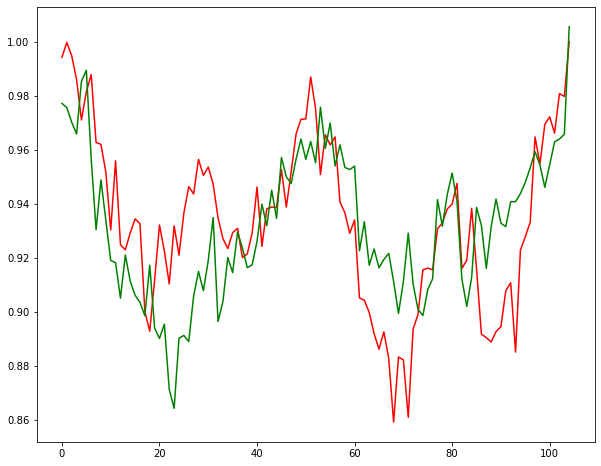

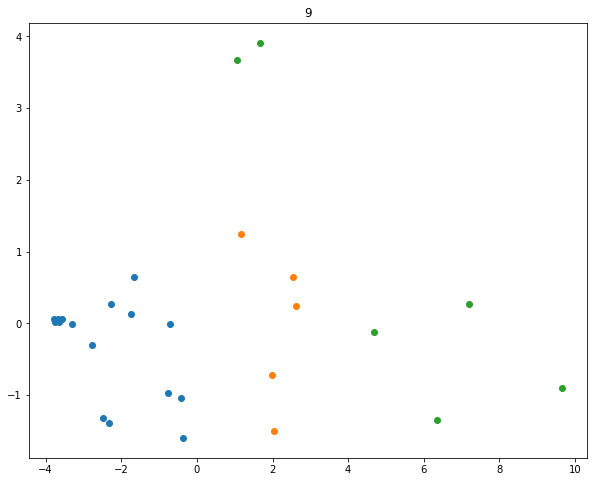

In [31]:
p9=pipeline(9,5000)

In [32]:
p7.to_csv('data/csv/cluster_7_5000.csv',columns=['State','cluster'], index=False)

In [33]:
p9.to_csv('data/csv/cluster_9_5000.csv',columns=['State','cluster'], index=False)